In [1]:
# Cache Warm-up and Optimization
import os
import time
import sys
import torch
import numpy as np
from PIL import Image

In [2]:
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats

Deformable Transformer Encoder is not available.


/media/Datacenter_storage/Ji/HOME_MEDIA/miniconda3/envs/biomedparse/lib/python3.9/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/media/Datacenter_storage/Ji/HOME_MEDIA/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### Model Setup

In [3]:
import os
# Set GPU device
gpu = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
torch.cuda.set_device(0)  # After setting CUDA_VISIBLE_DEVICES, use device 0

# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
# opt = load_opt_from_config_files(["/media/Datacenter_storage/Ji/BiomedParse/configs/biomed_seg_lang_v1.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
# pretrained_pth = ':microsoft/BiomedParse'
# pretrained_pth = '/media/Datacenter_storage/Ji/BiomedParse/output/biomed_seg_lang_v1.yaml_conf~/run_38/00025920/default/model_state_dict.pt'
pretrained_pth = "/media/Datacenter_storage/Ji/BiomedParse/output/biomed_seg_lang_v1.yaml_conf~/run_48/00025440/default/model_state_dict.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/media/Datacenter_storage/Ji/HOME_MEDIA/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


### Utility Functions

In [48]:
SEGMENTATION_THRESHOLD = 0.5

def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    # ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    # print("segmentation_masks", segmentation_masks)
    # print("segmentation_masks.shape", segmentation_masks.shape)

    for i, mask in enumerate(segmentation_masks):
        print(i)
        # ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        # mask_temp[mask >= SEGMENTATION_THRESHOLD] = [255, 0, 0]
        mask_temp[mask >= SEGMENTATION_THRESHOLD] = [255, 255, 255]
        mask_temp[mask < SEGMENTATION_THRESHOLD] = [0, 0, 0, ]
        ax[i+1].imshow(mask_temp, alpha=1.0)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)

    plt.show()

In [5]:
# !pip install pydicom nibabel SimpleITK
import json
import matplotlib.pyplot as plt
from inference_utils.processing_utils import read_rgb


def inference_rgb(file_path, text_prompts):
    image = read_rgb(file_path)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)


    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts)
    
    return image, pred_mask

#### Get Cell Instances

In [6]:
# from inference_utils.processing_utils import get_instances

# def plot_instance_segmentation_masks(original_image, segmentation_masks, text_prompt=None):
#     ''' Plot a list of segmentation mask over an image.
#     '''
#     original_image = original_image[:, :, :3]
#     fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
#     ax[0].imshow(original_image, cmap='gray')
#     ax[0].set_title('Original Image')
#     # grid off
#     for a in ax:
#         a.axis('off')

#     instance_masks = [get_instances(1*(mask>0.5)) for mask in segmentation_masks]
    
#     mask_names = [f'Mask {i+1}' for i in range(len(segmentation_masks))]
#     if text_prompt:
#         mask_names = text_prompt
#         for i in range(len(mask_names)):
#             mask_names[i] = mask_names[i].strip()


#     for i, mask in enumerate(instance_masks):
#         ins_ids = np.unique(mask)
#         count = len(ins_ids[ins_ids > 0])
        
#         ax[i+1].set_title(f'{mask_names[i]} ({count})')
#         mask_temp = np.zeros_like(original_image)
#         for ins_id in ins_ids:
#             if ins_id == 0:
#                 continue
#             mask_temp[mask == ins_id] = np.random.randint(0, 255, 3)
#             if ins_id == 1:
#                 mask_temp[mask == ins_id] = [255, 0, 0]
        
#         ax[i+1].imshow(mask_temp, alpha=1)
#         ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)

#     plt.show()

### CSF Prediction

In [40]:
uid = "325"
slice = "024"
# train/sub-207-slice-108_MRI_Brain.png

0


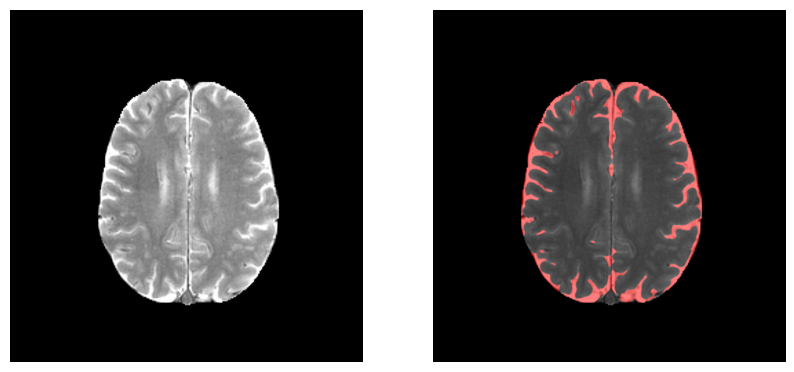

[[[3.72020956e-11 3.72020956e-11 9.92466005e-12 ... 2.18020378e-16
   6.89687154e-16 6.89687154e-16]
  [3.72020956e-11 3.72020956e-11 9.92466005e-12 ... 2.18020378e-16
   6.89687154e-16 6.89687154e-16]
  [9.86897456e-12 9.86897456e-12 2.71029271e-12 ... 5.31456430e-17
   1.59370281e-16 1.59370281e-16]
  ...
  [1.62402037e-16 1.62402037e-16 2.83665180e-17 ... 3.12348342e-18
   1.29408494e-17 1.29408494e-17]
  [1.22827210e-15 1.22827210e-15 2.00625445e-16 ... 1.98290248e-17
   9.00159648e-17 9.00159648e-17]
  [1.22827210e-15 1.22827210e-15 2.00625445e-16 ... 1.98290248e-17
   9.00159648e-17 9.00159648e-17]]]


In [47]:
# Valdo

# root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_VALDO/valdo_png_final_GAN_CMBONLY_ALLSEQ"
# image_path = f"{root_path}/images/val/sub-{uid}_slice_{slice}.png"
# root_path = "/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/loss_dev"
root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_VALDO/bias_field_correction_resampled_win_normalization_1021_min_max_t2s_yolo_resampling/images"
image_path = f"{root_path}/val/sub-{uid}_slice_{slice}.png"
# image_path = "/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/loss_dev/train/sub-207-slice-108_MRI_Brain.png"
# print(image_path)
# text_prompt = ['csf', 'cmb']
# text_prompt = ['brain microbleeds']
text_prompt = ['cerebrospinal fluid']
image, pred_mask = inference_rgb(image_path, text_prompt)
print(pred_mask)
# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])  # (image, pred_mask, Modality type, prompt)
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### CMB Prediction

0


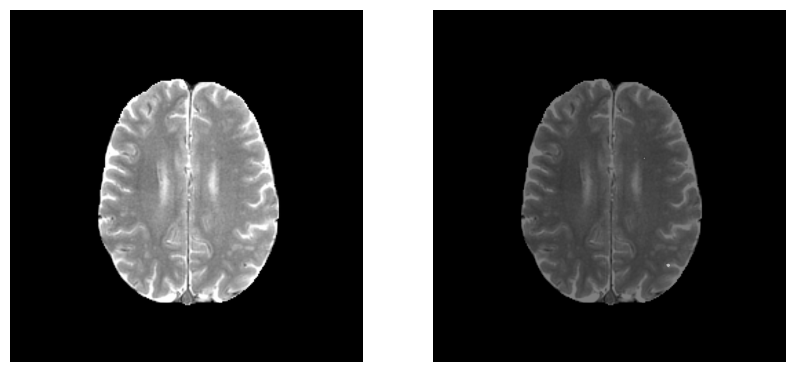

[[[5.692505e-39 5.692505e-39 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]
  [5.692505e-39 5.692505e-39 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]
  [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]
  ...
  [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]
  [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]
  [0.000000e+00 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
   0.000000e+00]]]


In [49]:
# Valdo
# uid = "110"
# slice = "011"
# root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_VALDO/valdo_png_final_GAN_CMBONLY_ALLSEQ"
# image_path = f"{root_path}/images/val/sub-{uid}_slice_{slice}.png"
root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_VALDO/bias_field_correction_resampled_win_normalization_1021_min_max_t2s_yolo_resampling/images"
image_path = f"{root_path}/val/sub-{uid}_slice_{slice}.png"
# print(image_path)
# text_prompt = ['csf', 'cmb']
text_prompt = ['brain microbleeds']
# text_prompt = ['cerebrospinal fluid']
image, pred_mask = inference_rgb(image_path, text_prompt)
print(pred_mask)
# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])  # (image, pred_mask, Modality type, prompt)
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

segmentation_masks [[[2.2197246e-36 2.2197246e-36 4.4708596e-39 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [2.2197246e-36 2.2197246e-36 4.4708596e-39 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [2.9992714e-38 2.9992714e-38 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]]
segmentation_masks.shape (1, 1024, 1024)
0


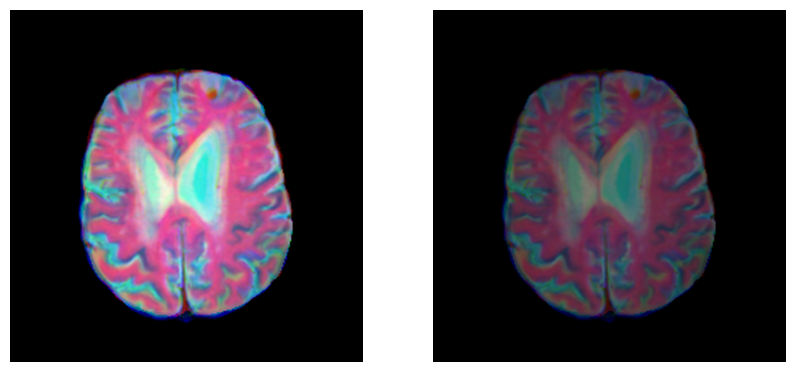

In [10]:
# Mayo
uid = "4817777"
slice = "30"
root_path = "/media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_MAYO/mayo_allsequence_png"
image_path = f"{root_path}/images/test/{uid}_{slice}.png"
# /media/Datacenter_storage/PublicDatasets/cerebral_microbleeds_MAYO/mayo_allsequence_png/images/test/4798157_22.png


# Valdo
# uid = "103"
# slice = "019"
# # test/sub-103-slice-019_MRI_Brain.png
# root_path = "/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/valdo_biomedparse_csf_cmbonly"
# image_path = f"{root_path}/test/sub-{uid}-slice-{slice}_MRI_Brain.png"
# /media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/valdo_biomedparse_csf_cmbonly/test/sub-103-slice-019_MRI_Brain.png

text_prompt = ['cmb']
image, pred_mask = inference_rgb(image_path, text_prompt)
# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])  # (image, pred_mask, Modality type, prompt)
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Pathology Example

In [11]:
# image_path = 'examples/CT_lung_nodule.dcm'
# text_prompt = ['nodule']

# image_path = 'examples/Part_1_516_pathology_breast.png'
# text_prompt = ['neoplastic cells', 'inflammatory cells', 'connective tissue cells']

# image, pred_mask = inference_rgb(image_path, text_prompt)

# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Pathology', text_prompt[i])
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

In [12]:
# plot_instance_segmentation_masks(image, pred_mask, text_prompt)

### X-Ray Example

segmentation_masks [[[1.0821489e-08 1.0821489e-08 5.0924993e-09 ... 4.6681486e-10
   1.0406322e-09 1.0406322e-09]
  [1.0821489e-08 1.0821489e-08 5.0924993e-09 ... 4.6681486e-10
   1.0406322e-09 1.0406322e-09]
  [6.6491843e-09 6.6491843e-09 3.0024805e-09 ... 1.7299499e-10
   4.2701598e-10 4.2701598e-10]
  ...
  [1.3871569e-09 1.3871569e-09 4.8407833e-10 ... 2.2439743e-07
   3.8214480e-07 3.8214480e-07]
  [4.6543351e-09 4.6543351e-09 1.8694850e-09 ... 5.9024717e-07
   9.8209375e-07 9.8209375e-07]
  [4.6543351e-09 4.6543351e-09 1.8694850e-09 ... 5.9024717e-07
   9.8209375e-07 9.8209375e-07]]

 [[1.0821489e-08 1.0821489e-08 5.0924993e-09 ... 4.6681486e-10
   1.0406322e-09 1.0406322e-09]
  [1.0821489e-08 1.0821489e-08 5.0924993e-09 ... 4.6681486e-10
   1.0406322e-09 1.0406322e-09]
  [6.6491843e-09 6.6491843e-09 3.0024805e-09 ... 1.7299499e-10
   4.2701598e-10 4.2701598e-10]
  ...
  [1.3871569e-09 1.3871569e-09 4.8407833e-10 ... 2.2439743e-07
   3.8214480e-07 3.8214480e-07]
  [4.6543351e-09 

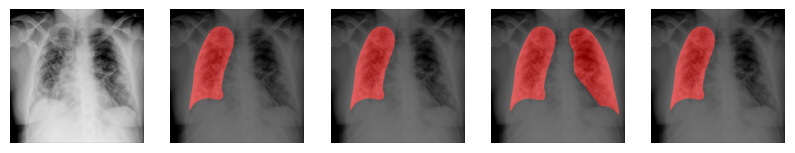

left lung P-value: 0.22640633475247623
right lung P-value: 0.20975709127615055


ValueError: Currently support targets for X-Ray-Chest: ['left lung', 'lung', 'right lung']

In [13]:
image_path = 'examples/covid_1585.png'
text_prompt = ['left lung', 'right lung', 'COVID-19 infection', 'dummy prompt']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)-1):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'X-Ray-Chest', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Fundus Example

segmentation_masks [[[1.8628370e-08 1.8628370e-08 4.2527435e-09 ... 3.6185303e-15
   3.0028683e-14 3.0028683e-14]
  [1.8628370e-08 1.8628370e-08 4.2527435e-09 ... 3.6185303e-15
   3.0028683e-14 3.0028683e-14]
  [3.9885957e-09 3.9885957e-09 7.2829998e-10 ... 2.5861345e-16
   2.8932757e-15 2.8932757e-15]
  ...
  [4.3789897e-15 4.3789897e-15 2.3210010e-16 ... 5.9120609e-19
   2.2058013e-17 2.2058013e-17]
  [4.2075742e-14 4.2075742e-14 2.8107814e-15 ... 1.4157603e-17
   3.9931105e-16 3.9931105e-16]
  [4.2075742e-14 4.2075742e-14 2.8107814e-15 ... 1.4157603e-17
   3.9931105e-16 3.9931105e-16]]

 [[8.7366534e-13 8.7366534e-13 3.8619563e-14 ... 2.2651026e-21
   1.3475757e-19 1.3475757e-19]
  [8.7366534e-13 8.7366534e-13 3.8619563e-14 ... 2.2651026e-21
   1.3475757e-19 1.3475757e-19]
  [4.7961452e-14 4.7961452e-14 1.4527175e-15 ... 4.2020052e-23
   4.3140478e-21 4.3140478e-21]
  ...
  [3.8108847e-20 3.8108847e-20 4.4891330e-22 ... 1.4396363e-24
   3.4546054e-22 3.4546054e-22]
  [1.8997787e-18 

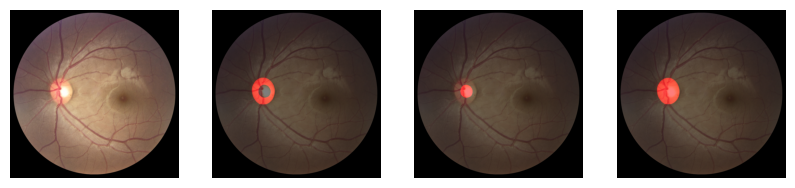

optic disc P-value: 0.6482181034327678
optic cup P-value: 0.5601010908213095


ValueError: Currently support targets for Fundus: ['optic cup', 'optic disc']

: 

: 

: 

In [ ]:
image_path = 'examples/T0011.jpg'
text_prompt = ['optic disc', 'optic cup', 'dummy prompt']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Fundus', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Endoscope Example

segmentation_masks [[[1.0918958e-05 1.0918958e-05 4.2198503e-06 ... 3.7343320e-09
   9.1081063e-09 9.1081063e-09]
  [1.0918958e-05 1.0918958e-05 4.2198503e-06 ... 3.7343320e-09
   9.1081063e-09 9.1081063e-09]
  [4.9996070e-06 4.9996070e-06 1.8496843e-06 ... 1.2356000e-09
   3.3292549e-09 3.3292549e-09]
  ...
  [3.0698697e-08 3.0698697e-08 8.8432488e-09 ... 4.5163362e-09
   1.4812959e-08 1.4812959e-08]
  [9.8638374e-08 9.8638374e-08 3.1338825e-08 ... 1.9250553e-08
   5.6239983e-08 5.6239983e-08]
  [9.8638374e-08 9.8638374e-08 3.1338825e-08 ... 1.9250553e-08
   5.6239983e-08 5.6239983e-08]]

 [[1.0918958e-05 1.0918958e-05 4.2198503e-06 ... 3.7343320e-09
   9.1081063e-09 9.1081063e-09]
  [1.0918958e-05 1.0918958e-05 4.2198503e-06 ... 3.7343320e-09
   9.1081063e-09 9.1081063e-09]
  [4.9996070e-06 4.9996070e-06 1.8496843e-06 ... 1.2356000e-09
   3.3292549e-09 3.3292549e-09]
  ...
  [3.0698697e-08 3.0698697e-08 8.8432488e-09 ... 4.5163362e-09
   1.4812959e-08 1.4812959e-08]
  [9.8638374e-08 

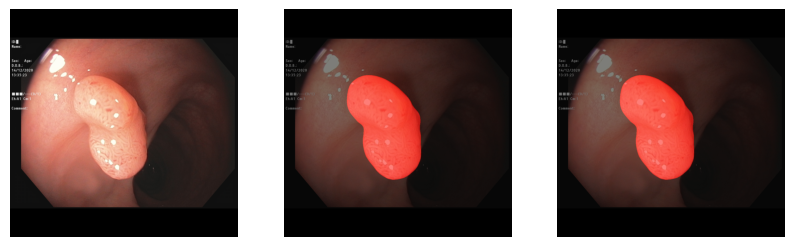

polyp P-value: 0.28710896839509487


ValueError: Currently support targets for Endoscopy: ['neoplastic polyp', 'polyp', 'non-neoplastic polyp']

: 

: 

: 

In [ ]:
image_path = 'examples/C3_EndoCV2021_00462.jpg'
text_prompt =   

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Endoscopy', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Dermoscopy Example

In [ ]:
# image_path = 'examples/ISIC_0015551.jpg'
# text_prompt = ['lesion']

# image, pred_mask = inference_rgb(image_path, text_prompt)

# # for i in range(len(pred_mask)):
# #     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Dermoscopy', text_prompt[i])
# #     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

: 

: 

: 

### OCT Example

In [ ]:
# image_path = 'examples/144DME_as_F.jpeg'
# text_prompt = ['edema']

# image, pred_mask = inference_rgb(image_path, text_prompt)

# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'OCT', text_prompt[i])
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

: 

: 

: 

### Cerebral Microbleeds

In [ ]:
# image_path = '/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/valdo_biomedparse/test/sub-317-slice-025_MRI_Brain.png'
# text_prompt = ['cmb']

# image, pred_mask = inference_rgb(image_path, text_prompt)

# # for i in range(len(pred_mask)):
# #     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])  # (image, pred_mask, Modality type, prompt)
# #     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

: 

: 

: 

In [ ]:
# image_path = '/media/Datacenter_storage/Ji/BiomedParse/biomedparse_datasets/valdo_biomedparse/test/sub-103-slice-017_MRI_Brain.png'
# text_prompt = ['edema']

# image, pred_mask = inference_rgb(image_path, text_prompt)

# for i in range(len(pred_mask)):
#     adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])  # (image, pred_mask, Modality type, prompt)
#     print(f'{text_prompt[i]} P-value: {adj_pvalue}')

: 

: 

: 